In [1]:
pip install gymnasium numpy matplotlib tensorflow

  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-1.0.0-py3-none-any.whl (958 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 4.7 MB/s eta 0:00:00a 0:00:02
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class ComplexMazeEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), start=(3, 3), goal=(8, 1), obstacles=None):
        super(ComplexMazeEnv, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start

        # Define action space (Up, Down, Left, Right)
        self.action_space = spaces.Discrete(4)

        # Define state space (2D coordinates)
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # Define obstacles
        self.obstacles = obstacles if obstacles else [(3,3), (3,4), (3,5), (5,6), (6,6), (7,6)]

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size[0] - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size[1] - 1)

        if (x, y) in self.obstacles:
            x, y = self.state  # Stay in place if obstacle

        self.state = (x, y)

        # Reward system
        reward = 10 if self.state == self.goal else -0.1
        done = self.state == self.goal

        return np.array(self.state, dtype=np.int32), reward, done, {}

    def reset(self):
        self.state = self.start
        return np.array(self.state, dtype=np.int32)

    def render(self):
        grid = np.zeros(self.grid_size)
        grid[self.goal] = 2
        for ob in self.obstacles:
            grid[ob] = -1
        grid[self.state] = 1
        print(grid)


In [62]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time

class LargeMazeEnv(gym.Env):
    def __init__(self, grid_size=(15, 15), start=(11, 6), goal=(1, 1)):  # Updated start and goal
        super(LargeMazeEnv, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start

        # Define action space (Up, Down, Left, Right)
        self.action_space = spaces.Discrete(4)

        # Define state space (2D coordinates)
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # Generate a solvable maze with obstacles
        self.maze = self.generate_solvable_maze()
        self.obstacles = [(i, j) for i in range(grid_size[0]) for j in range(grid_size[1]) if self.maze[i, j] == 1]

    def generate_solvable_maze(self):
        maze = np.ones(self.grid_size)  # Start with walls (1 = wall, 0 = open path)

        def carve_path(x, y):
            maze[x, y] = 0  # Mark as open path
            
            directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
            random.shuffle(directions)  # Randomize path carving

            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 1 <= nx < self.grid_size[0] - 1 and 1 <= ny < self.grid_size[1] - 1 and maze[nx, ny] == 1:
                    maze[nx - dx // 2, ny - dy // 2] = 0  # Carve through wall
                    carve_path(nx, ny)  # Recursive call

        # Start maze carving from a position near the start
        carve_path(1, 1)

        # Ensure the start and goal are open
        maze[self.start] = 0
        maze[self.goal] = 0

        return maze

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size[0] - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size[1] - 1)

        if (x, y) in self.obstacles:
            x, y = self.state  # Stay in place if hitting an obstacle

        self.state = (x, y)

        # Reward system: Encourage reaching the goal efficiently
        reward = 10 if self.state == self.goal else -0.1
        done = self.state == self.goal

        return np.array(self.state, dtype=np.int32), reward, done, {}

    def reset(self):
        self.state = self.start
        return np.array(self.state, dtype=np.int32), {}  # Return state and empty info dict

    def render(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap="gray_r", origin="upper")
        plt.scatter(self.start[1], self.start[0], color='green', label="Start")  # Start point
        plt.scatter(self.goal[1], self.goal[0], color='red', label="Goal")  # Goal point
        plt.legend()
        plt.title("20x20 Solvable Maze")
        plt.show()

In [63]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import time

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model = self.build_model()

        self.memory = []
        self.rewards_per_episode = []  
        self.update_frequency = 10  # Train steps

    def build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(16, activation="relu", input_shape=(2,)),  # Even smaller model
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dense(self.env.action_space.n, activation="linear")
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.alpha), loss="mse")
        return model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Random action (exploration)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])  # Choose best action (exploitation)

    def train_agent(self, episodes=100, batch_size=16):
        start_time = time.time()
        for episode in range(episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            step_count = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward
                step_count += 1

                # Train only every 10 steps (reduces compute cost)
                if len(self.memory) >= batch_size and step_count % self.update_frequency == 0:
                    self.train(batch_size)

            self.rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Print progress every 10 episodes
            if episode % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"✔️ Episode {episode} Complete | Total Reward: {total_reward} | Steps: {step_count} | Time: {elapsed_time:.2f}s")

    def train(self, batch_size=16):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)

        for i in range(batch_size):
            target = rewards[i] if dones[i] else rewards[i] + self.gamma * np.max(next_q_values[i])
            q_values[i][actions[i]] = target

        self.model.fit(states, q_values, epochs=1, verbose=0, batch_size=batch_size)

    def plot_training_progress(self):
        plt.figure(figsize=(10, 5))
    
        # Plot Total Rewards
        plt.subplot(2, 1, 1)
        plt.plot(self.rewards_per_episode, label="Total Reward per Episode", color="blue")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("DQN Training Progress - Rewards")
        plt.legend()
    
        plt.tight_layout()
        plt.show()


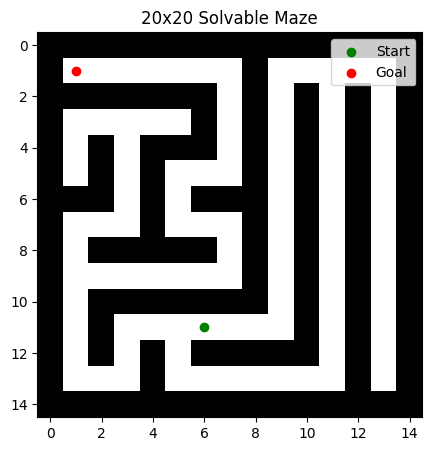

In [64]:
def visualize_trained_agent(env, agent):
    state, _ = env.reset()
    done = False
    path = [state]

    while not done:
        action = agent.choose_action(state)
        state, _, done, _ = env.step(action)
        path.append(state)

    grid = np.zeros(env.grid_size)
    for step in path:
        grid[tuple(step)] = 0.5  
    grid[env.start] = 1.0  
    grid[env.goal] = 2.0  
    for ob in env.obstacles:
        grid[ob] = -1  

    plt.figure(figsize=(5,5))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.title("DQN Agent Learned Path")
    plt.show()

# Initialize environment and train the agent

env = LargeMazeEnv()
env.render()
agent = DQNAgent(env)



In [65]:
agent.train_agent(episodes=100)

✔️ Episode 0 Complete | Total Reward: -496.2000000000466 | Steps: 5063 | Time: 114.72s
✔️ Episode 10 Complete | Total Reward: -117.69999999999702 | Steps: 1278 | Time: 1598.74s
✔️ Episode 20 Complete | Total Reward: -923.7000000001437 | Steps: 9338 | Time: 3386.00s
✔️ Episode 30 Complete | Total Reward: -48.90000000000057 | Steps: 590 | Time: 5697.59s
✔️ Episode 40 Complete | Total Reward: -41.50000000000046 | Steps: 516 | Time: 7902.95s
✔️ Episode 50 Complete | Total Reward: -26.800000000000253 | Steps: 369 | Time: 9262.98s
✔️ Episode 60 Complete | Total Reward: -257.7999999999924 | Steps: 2679 | Time: 13613.40s
✔️ Episode 70 Complete | Total Reward: -78.09999999999927 | Steps: 882 | Time: 20290.54s
✔️ Episode 80 Complete | Total Reward: -492.2000000000457 | Steps: 5023 | Time: 23420.27s
✔️ Episode 90 Complete | Total Reward: -618.5000000000744 | Steps: 6286 | Time: 25366.65s


AttributeError: 'DQNAgent' object has no attribute 'steps_per_episode'

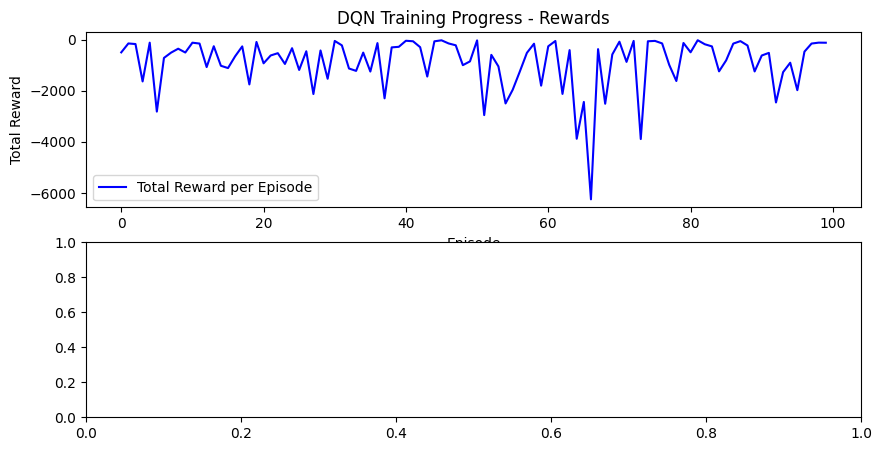

In [66]:
agent.plot_training_progress()
visualize_trained_agent(env, agent)

In [68]:
def test_trained_agent(env, agent, episodes=10):
    """Test the trained agent on the maze and measure performance."""
    agent.epsilon = 0  # Disable exploration (always choose the best action)
    success_count = 0
    total_steps = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        path = [tuple(state)]  # Convert to tuple for proper indexing

        while not done:
            action = agent.choose_action(state)  # Always choose the best action
            state, _, done, _ = env.step(action)
            path.append(tuple(state))
            steps += 1

            # Prevent infinite loops
            if steps > 500:
                print(f"⚠️ Episode {episode} took too long, possible failure!")
                break

        # Correct comparison for NumPy arrays
        if np.array_equal(state, env.goal):
            success_count += 1
            total_steps.append(steps)

        print(f"Episode {episode}: Steps Taken = {steps}")

    # Print overall performance
    success_rate = (success_count / episodes) * 100
    avg_steps = np.mean(total_steps) if total_steps else float('inf')

    print("\nTesting Results:")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Steps to Goal: {avg_steps:.2f}")

def visualize_trained_path(env, agent):
    """Visualize the trained agent's movement through the maze."""
    agent.epsilon = 0  # Ensure greedy policy
    state, _ = env.reset()
    done = False
    path = [tuple(state)]

    while not done:
        action = agent.choose_action(state)
        state, _, done, _ = env.step(action)
        path.append(tuple(state))

    grid = np.zeros(env.grid_size)
    for step in path:
        grid[step] = 0.5  # Gray for path
    grid[tuple(env.start)] = 1.0  # Green for start
    grid[tuple(env.goal)] = 2.0  # Red for goal
    for ob in env.obstacles:
        grid[ob] = -1  # Black for obstacles

    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.title("Trained Agent's Path in Maze")
    plt.show()

# Run the testing and visualization
print("Running Trained Model Test...")
test_trained_agent(env, agent, episodes=10)

print("Visualizing Learned Path...")
visualize_trained_path(env, agent)


🚀 Running Trained Model Test...
⚠️ Episode 0 took too long, possible failure!
Episode 0: Steps Taken = 501
⚠️ Episode 1 took too long, possible failure!
Episode 1: Steps Taken = 501
⚠️ Episode 2 took too long, possible failure!
Episode 2: Steps Taken = 501
⚠️ Episode 3 took too long, possible failure!
Episode 3: Steps Taken = 501
⚠️ Episode 4 took too long, possible failure!
Episode 4: Steps Taken = 501
⚠️ Episode 5 took too long, possible failure!
Episode 5: Steps Taken = 501
⚠️ Episode 6 took too long, possible failure!
Episode 6: Steps Taken = 501
⚠️ Episode 7 took too long, possible failure!
Episode 7: Steps Taken = 501
⚠️ Episode 8 took too long, possible failure!
Episode 8: Steps Taken = 501
⚠️ Episode 9 took too long, possible failure!
Episode 9: Steps Taken = 501

🎯 Testing Results:
✅ Success Rate: 0.00%
📉 Average Steps to Goal: inf
🚀 Model Performance: NEEDS IMPROVEMENT
📍 Visualizing Learned Path...


KeyboardInterrupt: 